# ECE 132A Final Project by Atharva Padhye and Kimber King


## Introduction

In this project we consider several modulation schemes such as QAM, QAM16, QAM64, BPSK ,PSK8 and compute the exact and approximate LLRs. We then build a nueral network and train it on various SNR values. Afterwards we test the network on new SNRs and observe its performance. 


In [3]:
import keras
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras import optimizers, regularizers
from keras.layers import Layer, Activation, Dense
from keras.layers import Dense, Dropout, Embedding, LSTM, MaxPooling1D, CuDNNLSTM

/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/atharvapadhye/an

In [4]:
#def to automatically generate symbols of QAM and M-Ary PSK
#didn't do any forward error correction because it wasn't going to affect loss function

def gray_code(x):
    if x < 1:
        y = []
    else:
        y = ['0', '1']
        x -= 1
        while x > 0:
            k = len(y)
            for i in range(k-1, -1, -1):
                char = y[i] + '1' 
                y.append(char)
            for i in range(k-1, -1, -1):
                y[i] = y[i] + '0'
            x -= 1
    return y

class BasicModem:
    def RX(self, symAry): #hard demodulation no coding schemes, analog to digital
        index_list = []
        for symbol in symAry:
            index_list.append(np.argmin(abs(symbol - self.coords)))
        output = ''
        for i in index_list:
            output += self.dict[self.coords[i]]
        return output
    
    def TX(self, payload_data): #for string inputs, digital to analog
        syms_out = np.zeros(int(len(payload_data)/self.bit_num), dtype=np.complex64)
        counter = 0
        for i in range(0, len(payload_data) - self.bit_num, self.bit_num):
            syms_out[counter] = self.inv_dict[payload_data[i:i+self.bit_num]]
            counter += 1
        return syms_out
    

class QAM(BasicModem):
    def __init__(self, NUM_SYMBOLS = 4, SAMP_RATE = 1):
        self.NUM_SYMBOLS = NUM_SYMBOLS
        self.SAMP_RATE = SAMP_RATE
        dim_iq_axis = int(np.sqrt(NUM_SYMBOLS))
        self.coords = []
        self.symbols = gray_code(np.log2(NUM_SYMBOLS))
        MAX_ENERGY = np.sqrt(2) #For QAM with coordinates at (x=1,y=1), normalized energy: divide by sqrt(2)
        x = np.linspace(-1, 1, dim_iq_axis, dtype='complex64')
        x, y = np.meshgrid(x, x)
        self.coords = (x + y * 1j).flatten()
        self.dict = dict(zip(self.coords, self.symbols))
        self.inv_dict = dict(zip(self.symbols, self.coords))
        self.bit_num = int(np.log2(NUM_SYMBOLS))

class PSK(BasicModem):
    def __init__(self, NUM_SYMBOLS = 8, SAMP_RATE = 1):
        self.NUM_SYMBOLS = NUM_SYMBOLS
        self.SAMP_RATE = SAMP_RATE
        self.coords = np.zeros(NUM_SYMBOLS, dtype='complex64')
        self.symbols = gray_code(np.log2(NUM_SYMBOLS))
        #generates an array with the approximate locations of the symbols.
        cnt = 0
        for i in np.arange(0, 2*np.pi, 2*np.pi/NUM_SYMBOLS):
            #i is the phase
            self.coords[cnt] =  1*np.exp(1j*i)
            cnt += 1
        
        self.dict = dict(zip(self.coords, self.symbols))
        self.inv_dict = dict(zip(self.symbols, self.coords))
        self.bit_num = int(np.log2(NUM_SYMBOLS))
        print(self.dict)

        #Extra Credit
class rayleigh_multipath: #create a multipath channel with Rayleigh fading and AWGN, noise generator
    def __init__(self, var_awgn, var_rayleigh, pdp):
        self.sigma_awgn = np.sqrt(var_awgn)
        self.sigma_rayleigh = np.sqrt(var_rayleigh)
        self.pdp = np.array(pdp)
        self.l = self.pdp.size-1
        self.update_cir()

    def update_cir(self): #generate new CIR from the PDP with Rayleigh fading
        self.cir = np.sqrt(np.array(self.pdp))
        randray = np.random.rayleigh(self.sigma_rayleigh, self.cir.size)
        self.cir = self.cir*randray

    def awgn(self, symbols): #add white gaussian noise
        real_noise = np.random.randn(symbols.size)
        imag_noise = np.random.randn(symbols.size)
        noise = real_noise+1j*imag_noise
        return symbols+self.sigma_awgn*noise

    def apply_cir(self, symbols): #convolve the symbols with the CIR, filter multitap, power density vector
        if self.l != 0:
            self.old_symbols = symbols[-self.l:]
        symbols = np.convolve(symbols, self.cir) # applying CIR
        return symbols 

In [5]:
#check recieved symbol is generated orrectly, sanity checking
myqam4 = QAM(NUM_SYMBOLS=4) 
myqam16 = QAM(NUM_SYMBOLS=16)
myqam64 = QAM(NUM_SYMBOLS=64)
myBPSK = PSK(NUM_SYMBOLS = 2)
myPSK8 = PSK(NUM_SYMBOLS = 16)
myqam4.TX('100111')

{(1+0j): '0', (-1+1.2246469e-16j): '1'}
{(1+0j): '0000', (0.9238795+0.38268343j): '1000', (0.70710677+0.70710677j): '1100', (0.38268343+0.9238795j): '0100', (6.123234e-17+1j): '0110', (-0.38268343+0.9238795j): '1110', (-0.70710677+0.70710677j): '1010', (-0.9238795+0.38268343j): '0010', (-1+1.2246469e-16j): '0011', (-0.9238795-0.38268343j): '1011', (-0.70710677-0.70710677j): '1111', (-0.38268343-0.9238795j): '0111', (-1.8369701e-16-1j): '0101', (0.38268343-0.9238795j): '1101', (0.70710677-0.70710677j): '1001', (0.9238795-0.38268343j): '0001'}


array([1.-1.j, 1.+1.j, 0.+0.j], dtype=complex64)

In [6]:
# Authors: CommPy contributors
# License: BSD 3-Clause
# used as reference to build modems, didn't end up using

"""
==================================================
Modulation Demodulation (:mod:`commpy.modulation`)
==================================================
.. autosummary::
   :toctree: generated/
   PSKModem             -- Phase Shift Keying (PSK) Modem.
   QAMModem             -- Quadrature Amplitude Modulation (QAM) Modem.
   ofdm_tx              -- OFDM Transmit Signal Generation
   ofdm_rx              -- OFDM Receive Signal Processing
   mimo_ml              -- MIMO Maximum Likelihood (ML) Detection.
   kbest                -- MIMO K-best Schnorr-Euchner Detection.
   bit_lvl_repr         -- Bit level representation.
   max_log_approx       -- Max-log approximation.
"""
from itertools import product
import matplotlib.pyplot as plt
from numpy import arange, array, zeros, pi, cos, sin, sqrt, log2, argmin, \
    hstack, repeat, tile, dot, shape, concatenate, exp, \
    log, vectorize, empty, eye, kron, inf
from numpy.fft import fft, ifft
from numpy.linalg import qr, norm
from commpy.utilities import bitarray2dec, dec2bitarray

__all__ = ['PSKModem', 'QAMModem', 'ofdm_tx', 'ofdm_rx', 'mimo_ml', 'kbest', 'bit_lvl_repr', 'max_log_approx']

class Modem:
    def modulate(self, input_bits):
        """ Modulate (map) an array of bits to constellation symbols.
        Parameters
        ----------
        input_bits : 1D ndarray of ints
            Inputs bits to be modulated (mapped).
        Returns
        -------
        baseband_symbols : 1D ndarray of complex floats
            Modulated complex symbols.
        """
        mapfunc = vectorize(lambda i:
                            self.constellation[bitarray2dec(input_bits[i:i + self.num_bits_symbol])])

        baseband_symbols = mapfunc(arange(0, len(input_bits), self.num_bits_symbol))

        return baseband_symbols

    def demodulate(self, input_symbols, demod_type, noise_var=0):
        """ Demodulate (map) a set of constellation symbols to corresponding bits.
        Parameters
        ----------
        input_symbols : 1D ndarray of complex floats
            Input symbols to be demodulated.
        demod_type : string
            'hard' for hard decision output (bits)
            'soft' for soft decision output (LLRs)
        noise_var : float
            AWGN variance. Needs to be specified only if demod_type is 'soft'
        Returns
        -------
        demod_bits : 1D ndarray of ints
            Corresponding demodulated bits.
        """
        if demod_type == 'hard':
            index_list = map(lambda i: argmin(abs(input_symbols[i] - self.constellation)),
                             range(0, len(input_symbols)))
            demod_bits = array([dec2bitarray(i, self.num_bits_symbol) for i in index_list]).reshape(-1)

        elif demod_type == 'soft':
            demod_bits = zeros(len(input_symbols) * self.num_bits_symbol)
            for i in arange(len(input_symbols)):
                current_symbol = input_symbols[i]
                for bit_index in arange(self.num_bits_symbol):
                    llr_num = 0
                    llr_den = 0
                    for const_index in self.symbol_mapping:
                        if (const_index >> bit_index) & 1:
                            llr_num = llr_num + exp(
                                (-abs(current_symbol - self.constellation[const_index]) ** 2) / noise_var)
                        else:
                            llr_den = llr_den + exp(
                                (-abs(current_symbol - self.constellation[const_index]) ** 2) / noise_var)
                    demod_bits[i * self.num_bits_symbol + self.num_bits_symbol - 1 - bit_index] = log(llr_num / llr_den)
        else:
            raise ValueError('demod_type must be "hard" or "soft"')

        return demod_bits

    def plot_constellation(self):
        """ Plot the constellation """
        # init some arrays
        beta = self.num_bits_symbol
        numbit = '0' + str(beta) + 'b'
        Bin = []
        mot = []
        const = []

        # creation of w array
        reel = [pow(2, i) for i in range(beta // 2 - 1, -1, -1)]
        im = [1j * pow(2, i) for i in range(beta // 2 - 1, -1, -1)]
        w = concatenate((reel, im), axis=None)

        listBin = [format(i, numbit) for i in range(2 ** beta)]
        for e in listBin:
            for i in range(beta):
                Bin.append(ord(e[i]) - 48)
                if ord(e[i]) - 48 == 0:
                    mot.append(-1)
                else:
                    mot.append(1)
            const.append(dot(w, mot))
            mot = []
        symb = self.modulate(Bin)

        # plot the symbols
        x = symb.real
        y = symb.imag

        plt.plot(x, y, '+', linewidth=4)
        for i in range(len(x)):
            plt.text(x[i], y[i], listBin[i])

        plt.title('Constellation')
        plt.grid()
        plt.show()


class PSKModem(Modem):
    """ Creates a Phase Shift Keying (PSK) Modem object. """

    Es = 1

    def _constellation_symbol(self, i):
        return cos(2 * pi * (i - 1) / self.m) + sin(2 * pi * (i - 1) / self.m) * (0 + 1j)

    def __init__(self, m):
        """ Creates a Phase Shift Keying (PSK) Modem object.
        Parameters
        ----------
        m : int
            Size of the PSK constellation.
        """
        self.m = m
        self.num_bits_symbol = int(log2(self.m))
        self.symbol_mapping = arange(self.m)
        self.constellation = list(map(self._constellation_symbol,
                                      self.symbol_mapping))


class QAMModem(Modem):
    """ Creates a Quadrature Amplitude Modulation (QAM) Modem object."""

    def _constellation_symbol(self, i):
        return (2 * i[0] - 1) + (2 * i[1] - 1) * (1j)

    def __init__(self, m):
        """ Creates a Quadrature Amplitude Modulation (QAM) Modem object.
        Parameters
        ----------
        m : int
            Size of the QAM constellation.
        """

        self.m = m
        self.num_bits_symbol = int(log2(self.m))
        self.symbol_mapping = arange(self.m)
        mapping_array = arange(1, sqrt(self.m) + 1) - (sqrt(self.m) / 2)
        self.constellation = list(map(self._constellation_symbol,
                                      list(product(mapping_array, repeat=2))))
        self.Es = 2 * (self.m - 1) / 3


def ofdm_tx(x, nfft, nsc, cp_length):
    """ OFDM Transmit signal generation """

    nfft = float(nfft)
    nsc = float(nsc)
    cp_length = float(cp_length)
    ofdm_tx_signal = array([])

    for i in range(0, shape(x)[1]):
        symbols = x[:, i]
        ofdm_sym_freq = zeros(nfft, dtype=complex)
        ofdm_sym_freq[1:(nsc / 2) + 1] = symbols[nsc / 2:]
        ofdm_sym_freq[-(nsc / 2):] = symbols[0:nsc / 2]
        ofdm_sym_time = ifft(ofdm_sym_freq)
        cp = ofdm_sym_time[-cp_length:]
        ofdm_tx_signal = concatenate((ofdm_tx_signal, cp, ofdm_sym_time))

    return ofdm_tx_signal


def ofdm_rx(y, nfft, nsc, cp_length):
    """ OFDM Receive Signal Processing """

    num_ofdm_symbols = int(len(y) / (nfft + cp_length))
    x_hat = zeros([nsc, num_ofdm_symbols], dtype=complex)

    for i in range(0, num_ofdm_symbols):
        ofdm_symbol = y[i * nfft + (i + 1) * cp_length:(i + 1) * (nfft + cp_length)]
        symbols_freq = fft(ofdm_symbol)
        x_hat[:, i] = concatenate((symbols_freq[-nsc / 2:], symbols_freq[1:(nsc / 2) + 1]))

    return x_hat


def mimo_ml(y, h, constellation):
    """ MIMO ML Detection.
    parameters
    ----------
    y : 1D ndarray of complex floats
        Received complex symbols (shape: num_receive_antennas x 1)
    h : 2D ndarray of complex floats
        Channel Matrix (shape: num_receive_antennas x num_transmit_antennas)
    constellation : 1D ndarray of complex floats
        Constellation used to modulate the symbols
    """
    _, n = h.shape
    m = len(constellation)
    x_ideal = empty((n, pow(m, n)), complex)
    for i in range(0, n):
        x_ideal[i] = repeat(tile(constellation, pow(m, i)), pow(m, n - i - 1))
    min_idx = argmin(norm(y[:, None] - dot(h, x_ideal), axis=0))
    x_r = x_ideal[:, min_idx]

    return x_r


def kbest(y, h, constellation, K, noise_var=0, output_type='hard', demode=None):
    """ MIMO K-best Schnorr-Euchner Detection.
    Reference: Zhan Guo and P. Nilsson, 'Algorithm and implementation of the K-best sphere decoding for MIMO detection',
        IEEE Journal on Selected Areas in Communications, vol. 24, no. 3, pp. 491-503, Mar. 2006.
    Parameters
    ----------
    y : 1D ndarray
        Received complex symbols (length: num_receive_antennas)
    h : 2D ndarray
        Channel Matrix (shape: num_receive_antennas x num_transmit_antennas)
    constellation : 1D ndarray of floats
        Constellation used to modulate the symbols
    K : positive integer
        Number of candidates kept at each step
    noise_var : positive float
        Noise variance.
        *Default* value is 0.
    output_type : str
        'hard': hard output i.e. output is a binary word
        'soft': soft output i.e. output is a vector of Log-Likelihood Ratios.
        *Default* value is 'hard'
    demode : function with prototype binary_word = demode(point)
        Function that provide the binary word corresponding to a symbol vector.
    Returns
    -------
    x : 1D ndarray of constellation points or of Log-Likelihood Ratios.
        Detected vector (length: num_receive_antennas).
    raises
    ------
    ValueError
                If h has more columns than rows.
                If output_type is something else than 'hard' or 'soft'
    """
    nb_tx, nb_rx = h.shape
    if nb_rx > nb_tx:
        raise ValueError('h has more columns than rows')

    # QR decomposition
    q, r = qr(h)
    yt = q.conj().T.dot(y)

    # Initialization
    m = len(constellation)
    nb_can = 1

    if isinstance(constellation[0], complex):
        const_type = complex
    else:
        const_type = float
    X = empty((nb_rx, K * m), dtype=const_type)  # Set of current candidates
    d = tile(yt[:, None], (1, K * m))  # Corresponding distance vector
    d_tot = zeros(K * m, dtype=float)  # Corresponding total distance
    hyp = empty(K * m, dtype=const_type)  # Hypothesis vector

    # Processing
    for coor in range(nb_rx - 1, -1, -1):
        nb_hyp = nb_can * m

        # Copy best candidates m times
        X[:, :nb_hyp] = tile(X[:, :nb_can], (1, m))
        d[:, :nb_hyp] = tile(d[:, :nb_can], (1, m))
        d_tot[:nb_hyp] = tile(d_tot[:nb_can], (1, m))

        # Make hypothesis
        hyp[:nb_hyp] = repeat(constellation, nb_can)
        X[coor, :nb_hyp] = hyp[:nb_hyp]
        d[coor, :nb_hyp] -= r[coor, coor] * hyp[:nb_hyp]
        d_tot[:nb_hyp] += abs(d[coor, :nb_hyp]) ** 2

        # Select best candidates
        argsort = d_tot[:nb_hyp].argsort()
        nb_can = min(nb_hyp, K)  # Update number of candidate

        # Update accordingly
        X[:, :nb_can] = X[:, argsort[:nb_can]]
        d[:, :nb_can] = d[:, argsort[:nb_can]]
        d[:coor, :nb_can] -= r[:coor, coor, None] * hyp[argsort[:nb_can]]
        d_tot[:nb_can] = d_tot[argsort[:nb_can]]

    if output_type == 'hard':
        return X[:, 0]
    elif output_type == 'soft':
        return max_log_approx(y, h, noise_var, X[:, :nb_can], demode)
    else:
        raise ValueError('output_type must be "hard" or "soft"')

def bit_lvl_repr(H, w):
    """ Bit-level representation of matrix H with weights w.
    parameters
    ----------
    H   :   2D ndarray (shape : nb_rx, nb_tx)
            Channel Matrix.
    w   :   1D ndarray of complex (length : beta)
            Bit level representation weights. The length must be even.
    return
    ------
    A : 2D nbarray (shape : nb_rx, nb_tx*beta)
        Channel matrix adapted to the bit-level representation.
    """
    beta = len(w)
    if beta % 2 == 0:
        m, n = H.shape
        In = eye(n, n)
        kr = kron(In, w)
        return dot(H, kr)
    else:
        raise ValueError('Beta must be even.')


def max_log_approx(y, h, noise_var, pts_list, demode):
    """ Max-log demode
    parameters
    ----------
    y : 1D ndarray
        Received symbol vector (length: num_receive_antennas)
    h : 2D ndarray
        Channel Matrix (shape: num_receive_antennas x num_transmit_antennas)
    noise_var : positive float
        Noise variance
    pts_list : 2D ndarray of constellation points
        Set of points to compute max log approximation (points are column-wise).
        (shape: num_receive_antennas x num_points)
    demode : function with prototype binary_word = demode(point)
        Function that provide the binary word corresponding to a symbol vector.
    return
    ------
    LLR : 1D ndarray of floats
        Log-Likelihood Ratio for each bit (same length as the return of decode)
    """
    # Decode all pts
    nb_pts = pts_list.shape[1]
    bits = demode(pts_list.reshape(-1, order='F')).reshape(nb_pts, -1)  # Set of binary words (one word by row)

    # Prepare LLR computation
    nb_bits = bits.shape[1]
    LLR = empty(nb_bits)

    # Loop for each bit
    for k in range(nb_bits):
        # Select pts based on the k-th bit in the corresponding word
        pts0 = pts_list.compress(bits[:, k] == 0, axis=1)
        pts1 = pts_list.compress(bits[:, k] == 1, axis=1)

        # Compute the norms and add inf to handle empty set of points
        norms0 = hstack((norm(y[:, None] - h.dot(pts0), axis=0) ** 2, inf))
        norms1 = hstack((norm(y[:, None] - h.dot(pts1), axis=0) ** 2, inf))

        # Compute LLR
        LLR[k] = min(norms0) - min(norms1)

    return -LLR / (2 * noise_var)

In [7]:
qam4 = QAMModem(4)
qam16 = QAMModem(16)
qam64 = QAMModem(64)
bpsk = PSKModem(2)
psk8 = PSKModem(8)
'''Note that the QAM soft-demodulators simply dont work due to a divide by zero error!'''

'Note that the QAM soft-demodulators simply dont work due to a divide by zero error!'

In [8]:
def has_ith_bit(i = 0, bit = '0', symbol_mapping = {}): #check to see for a specific bit if there is a 0 or 1 in the ith index
    sym_list = []
    for symbol, bits in symbol_mapping.items():
        if bits[i] == bit:
            sym_list.append(symbol)
    return sym_list

def calc_llr(symbol_mapping, r, h = np.complex64(1.0), var = 1):
    #https://arxiv.org/pdf/1903.04656.pdf, used the paper to calc LLR
    Ls = []
    vals = list(symbol_mapping.values())
    for i in range(len(vals[0])):
        soft_symbols_1 = has_ith_bit(i = i, bit = '1', symbol_mapping = symbol_mapping)
        soft_symbols_0 = has_ith_bit(i = i, bit = '0', symbol_mapping = symbol_mapping)
        run_sum_1 = np.float64(0.0)
        run_sum_0 = np.float64(0.0)
        for local_s in soft_symbols_1:
            a = np.exp(-1*(np.linalg.norm(r-h*local_s))/var) #Minimum is to fix growing exponential bug for each SNR
            run_sum_1 += a
        for local_s in soft_symbols_0:
            a = np.exp(-1*(np.linalg.norm(r-h*local_s))/var) #Minimum is to fix growing exponential bug for each SNR
            run_sum_0 += a
        Li = np.float64(np.log2(run_sum_1)) - np.float64(np.log2(run_sum_0))
        Ls.append(Li)
    return Ls

    
def soft_demodulate(input_symbols, symbol_mapping, h = np.complex64(1.0), var = 1):
    #Code taken from CommPy: https://github.com/veeresht/CommPy/blob/master/commpy/modulation.py
    #LLR at specific bit tells you how likely the next bit will be 0 or 1.
    list_syms = np.array([ k for k in symbol_mapping.keys() ])
    list_bits = np.array([ v for v in symbol_mapping.values() ])
    str_out = ''
    for i in range(len(input_symbols)):
        llrs = calc_llr(symbol_mapping, input_symbols[i], h = h, var = var)
        for llr in llrs:
            if llr <= 0.0:
                str_out += '0'
            else:
                str_out += '1'
    return str_out

def generateModel(in_shape = 2, bps = 2): #use ML model
    model = Sequential()
    #add layers, only used 1 because it is not very complicated as calculating LLR only requires division and log
    model.add(Dense(in_shape, input_shape=(in_shape, )))
    model.add(Dense(in_shape*64, input_shape=(in_shape, )))
    model.add(Activation('relu'))
    model.add(Dense(bps, input_shape=(bps,),kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.0001)))
    model.summary()
    return model

In [9]:
print(myqam4.dict[-1-1j])
print(myqam16.dict[-1-1j])
print('calc_llr:', calc_llr(myqam4.dict, -1-1j, h = 1.0))
print('calc_llr:', calc_llr(myqam4.dict, -0.5+0.75j, h = 1.0))
print('calc_llr:', calc_llr(myqam4.dict, -0.5+0.75j, h = 1.0 + 2j))
print('calc_llr:', calc_llr(myqam16.dict, 0.75+0.75j, h = 1.0))
print('soft: ', soft_demodulate([-1-1j, -1+1j, 1+1j, 1-1j], myqam16.dict, h=1.0))
print('dict:', myqam16.dict)

print(myPSK8.dict)
print('calc_llr:', calc_llr(myPSK8.dict, 1, h = 1.0))
print('calc_llr:', calc_llr(myPSK8.dict, -1, h = 1.0))
print('calc_llr:', calc_llr(myBPSK.dict, 1, h = 1.0))
print('calc_llr:', calc_llr(myBPSK.dict, -1, h = 1.0))
print('soft: ', soft_demodulate([1, 1, -1, -1, 1, 1], myBPSK.dict, h=1.0))
print('dict:', myBPSK.dict)

00
0000
calc_llr: [-1.9682367243887073, -2.5457138269082145]
calc_llr: [0.8192674455538647, 1.5940402850823552]
calc_llr: [-0.6044061593021821, 1.628907464555101]
calc_llr: [0.1557260165832155, -0.17371323540141548, 0.1557260165832155, 1.1757619283683902]
soft:  0000010100010100
dict: {(-1-1j): '0000', (-0.33333334-1j): '1000', (0.33333334-1j): '1100', (1-1j): '0100', (-1-0.33333334j): '0110', (-0.33333334-0.33333334j): '1110', (0.33333334-0.33333334j): '1010', (1-0.33333334j): '0010', (-1+0.33333334j): '0011', (-0.33333334+0.33333334j): '1011', (0.33333334+0.33333334j): '1111', (1+0.33333334j): '0111', (-1+1j): '0101', (-0.33333334+1j): '1101', (0.33333334+1j): '1001', (1+1j): '0001'}
{(1+0j): '0000', (0.9238795+0.38268343j): '1000', (0.70710677+0.70710677j): '1100', (0.38268343+0.9238795j): '0100', (6.123234e-17+1j): '0110', (-0.38268343+0.9238795j): '1110', (-0.70710677+0.70710677j): '1010', (-0.9238795+0.38268343j): '0010', (-1+1.2246469e-16j): '0011', (-0.9238795-0.38268343j): '10

In [10]:
#predefines for running LLR simulation, generate randomized data, separate into training and test data
%matplotlib inline
from random import choice
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, KFold
RAND_DATA_CREATE = 64**2
RAYLEIGH_FADING = np.complex64(1.0)

SNRS = [1, 2, 3, 5, 10, 15, 20]
VARS = []
VAR_RAYLEIGH = 1.0

for snr in SNRS:
    snr_linear = 10**(snr / 10)
    VARS.append(np.float64(1/snr_linear)**2)
print('noise_variance:' , VARS)
    
myModems = [myqam4, myqam16, myqam64, myBPSK, myPSK8]
names = ['QAM', 'QAM16', 'QAM64','BPSK', 'PSK8']
NumberSymb = [4,16,64,2,8]
NumberBits = [ k for k in (np.int_(NumberSymb)) ]
history_list = []
model_list = []
data = ''.join(choice('01') for _ in range(RAND_DATA_CREATE))
Adam=optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
print('NumberBits', NumberBits)
#feed noise variance to AWGN noise generator to calculate LLR

noise_variance: [0.6309573444801932, 0.39810717055349726, 0.25118864315095807, 0.1, 0.010000000000000002, 0.0009999999999999998, 0.0001]
Instructions for updating:
Colocations handled automatically by placer.
NumberBits [4, 16, 64, 2, 8]


The following is the simulation that shows the Mean-Squared Error and how it varies among different SNRs. We tested SNRs from [-5, -2, 1, 2, 3, 5, 10, 15, 20] and then tested each for different modulation schemes (4QAM, 16QAM, 64QAM, BPSK, 8PSK). 

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


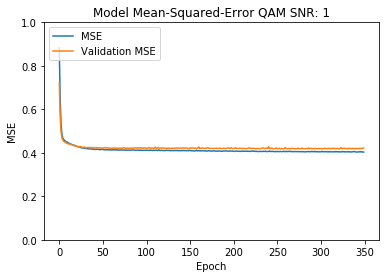

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


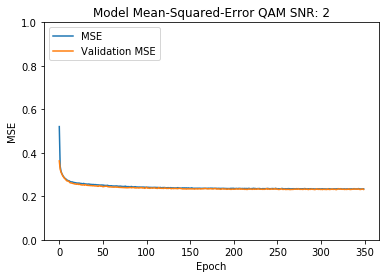

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               384       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


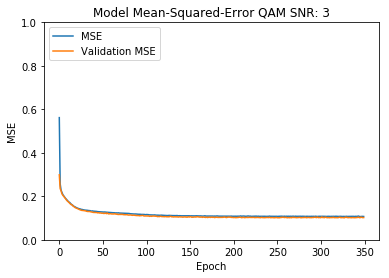

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


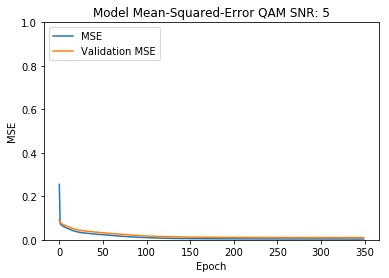

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


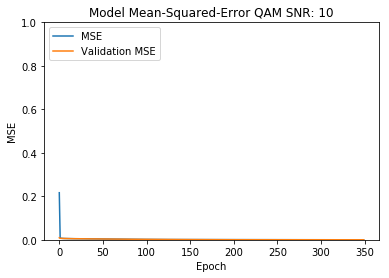

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 2)                 6         
_________________________________________________________________

/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars



dense_17 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


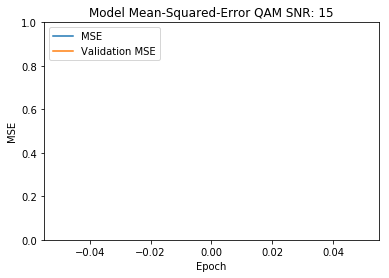

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


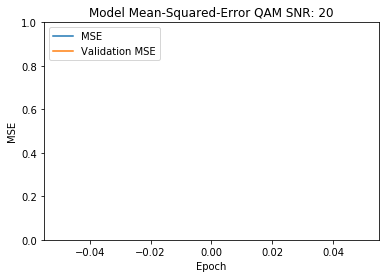

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


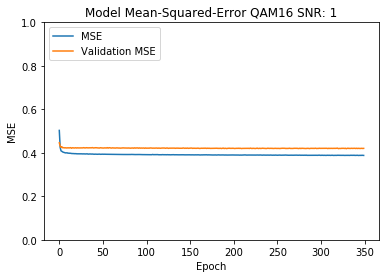

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_9 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


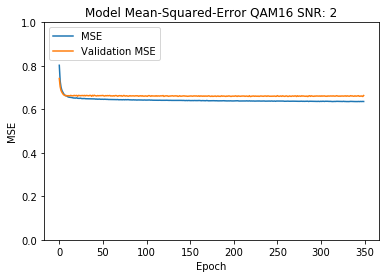

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


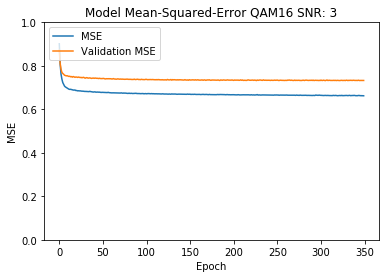

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


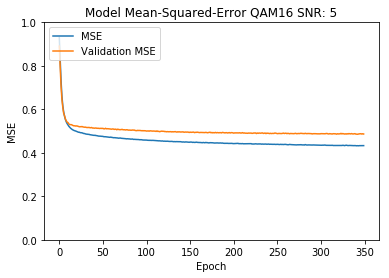

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


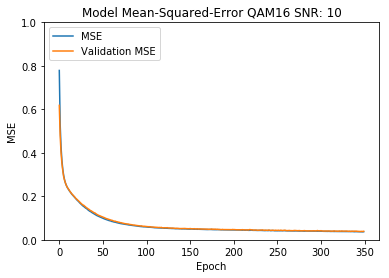

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


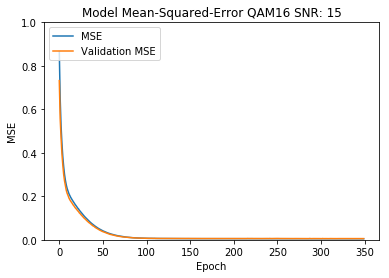

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_14 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


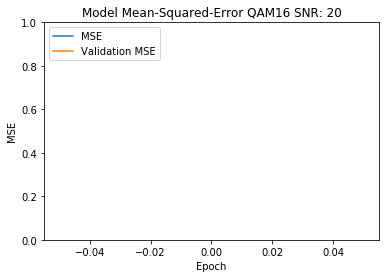

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


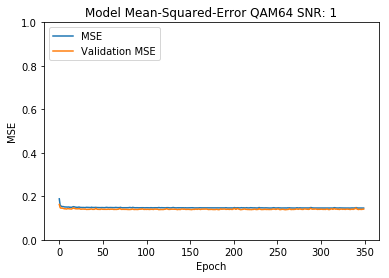

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


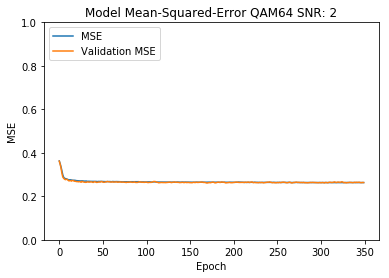

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


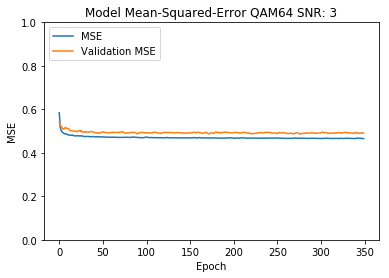

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_18 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


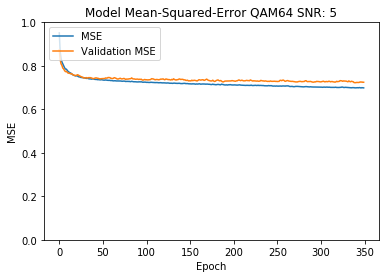

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_56 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_19 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


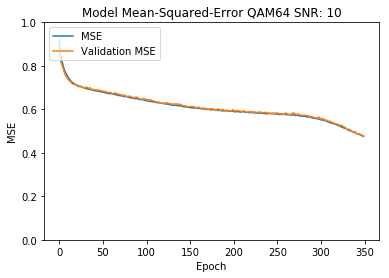

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_20 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


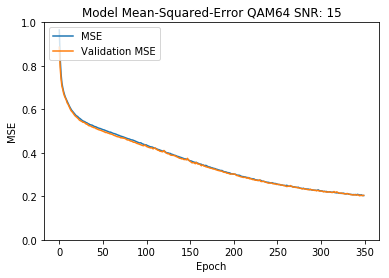

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_21 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


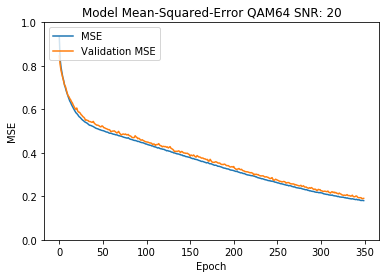

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_22 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


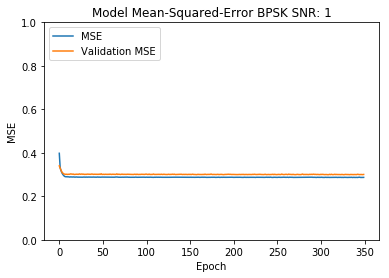

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_23 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


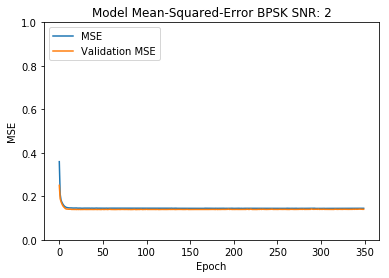

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_24 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


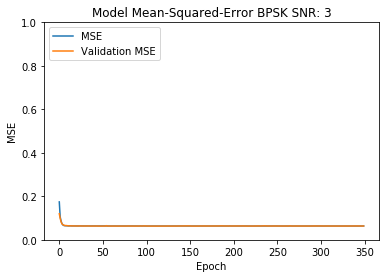

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_25 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


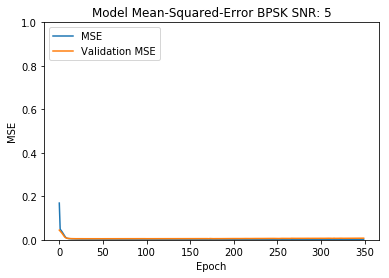

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_26 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


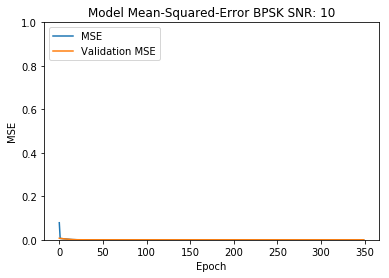

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_27 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


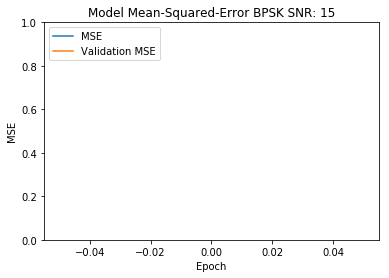

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_28 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


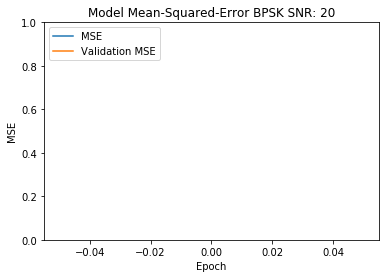

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_86 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_29 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


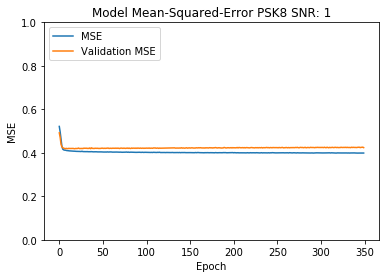

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_30 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


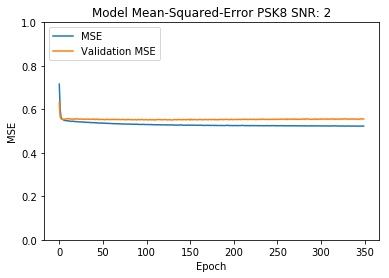

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_31 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


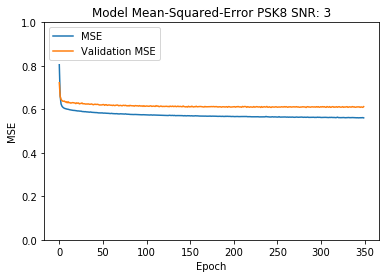

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_95 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_32 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


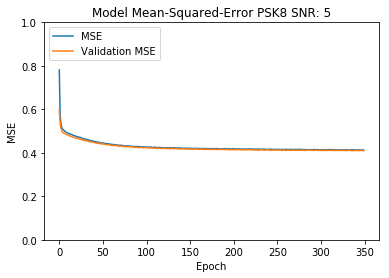

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_98 (Dense)             (None, 128)               384       
_________________________________________________________________
activation_33 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


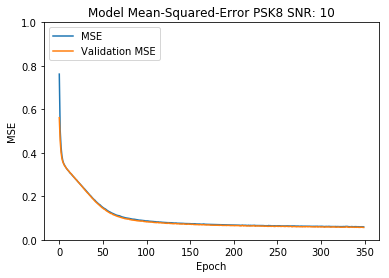

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_101 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_34 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


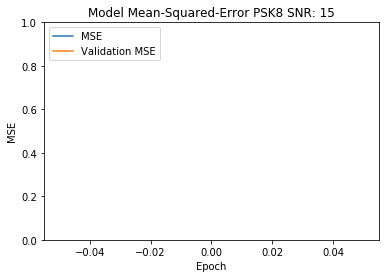

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_104 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_35 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


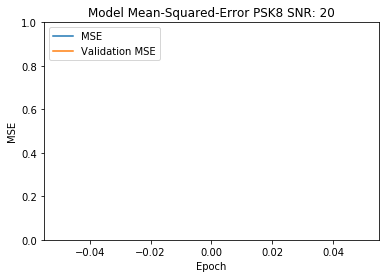

In [11]:
#FeedForward Simulation, used atom optimizer as it runs fast and goes through gradients and doesn't get stuck on local minimas
#can try to use RMSPROP
def run_simulation(myModems, VARS, SNRS, names, optimizer=Adam):
    counterIndex = 0
    for modem in myModems:
        for noise_var, snr in zip(VARS, SNRS):
            print(names[counterIndex])
            channel = rayleigh_multipath(noise_var, VAR_RAYLEIGH, [1.0, 0.7, 0.1, 0.3])
            myModel = generateModel(bps = modem.bit_num)
            #sending even number of bits through modulator
            
            if (names[counterIndex] != 'BPSK'):
                length = len(data)
                num_chunks = int(np.floor_divide(length, modem.bit_num))
                proc_data = data[:length*num_chunks]
            else:
                proc_data = data

            #adding AWGN and Rayleigh fading in channel
            TX_data = modem.TX(proc_data)
            X_pre = (channel.awgn(TX_data))
            X = []
            TX = []
            for x in X_pre:
                X.append([x.real, x.imag])
            for x in TX_data:
                TX.append([x.real, x.imag])
            X = np.array(X)
            TX = np.array(TX)
            y = []
            #calculate LLRs of the transmitted symbols before channels
            for symbol in TX:
                complex_symbol = symbol[0] + 1j*symbol[1]
                #calculate the LLRs off of the known approximate of gaussian  and rayleigh variances
                ele = calc_llr(modem.dict, complex_symbol, h=VAR_RAYLEIGH, var = noise_var)
                ele = np.tanh(ele)
                y.append(ele)

            y = np.array(y)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            myModel.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
            epochs = 350
            mselist = []
            val_mselist = []
            for i in range(epochs):
                history=myModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, verbose=False)
                mselist.append(history.history['mean_squared_error'])
                val_mselist.append(history.history['val_mean_squared_error'])
            #used MSE because it is a good regression problem to calculate LLR, seemed most obvious.
            #other methods include Mahattan distance and Euclidian distance
            model_list.append(myModel)
            fig = plt.figure()
            ax = plt.gca()
            ax.set_ylim(0, 1)
            plt.plot(mselist)
            plt.plot(val_mselist)
            plt.title('Model Mean-Squared-Error %s SNR: %s' % (names[counterIndex], snr))
            plt.ylabel('MSE')
            plt.xlabel('Epoch')
            plt.legend(['MSE', 'Validation MSE'], loc = 'upper left')
            plt.show()
        counterIndex += 1
run_simulation(myModems,VARS,SNRS,names,optimizer=Adam)
#overfitting can happen if you train a model for too long on a specific data set, used validation to see if overfitting isn't happening
#As SNR increase it gets converge to 0

From the results we see that higher SNRs result in the a lower MSE and a larger decresing slope of the MSE curve. 

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_212 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_71 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


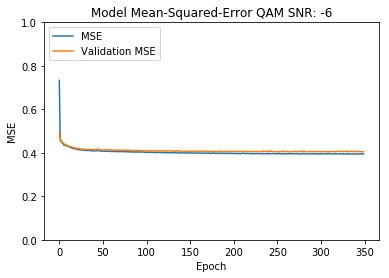

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_215 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_72 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


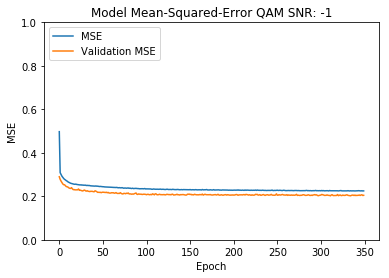

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_218 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_73 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_219 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


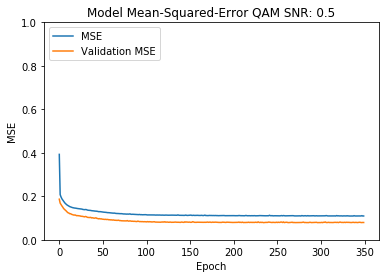

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_220 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_221 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_74 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


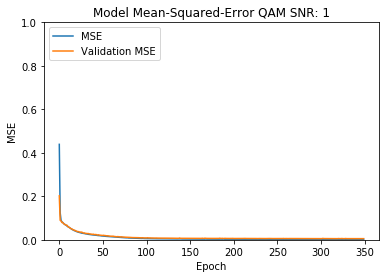

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_224 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_75 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


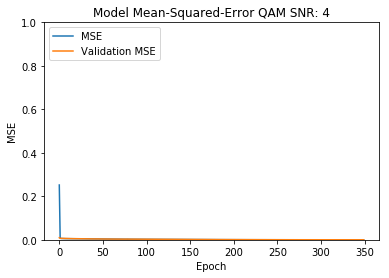

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_227 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_76 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_228 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


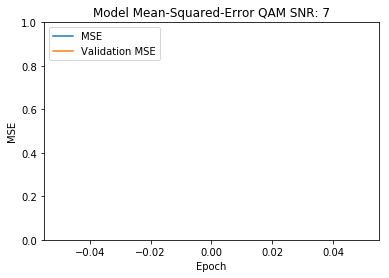

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_229 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_230 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_77 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


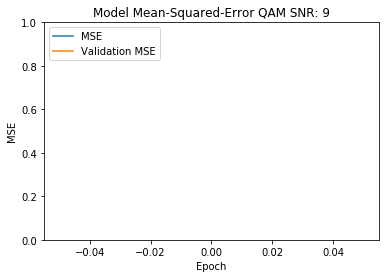

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_233 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_78 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


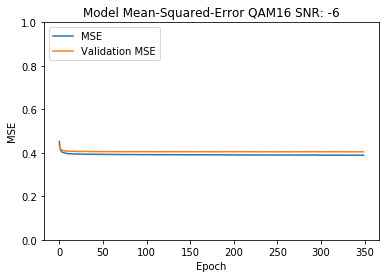

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_236 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_79 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_237 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


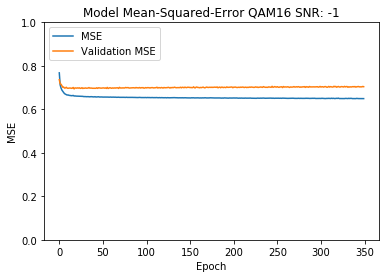

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_238 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_239 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_80 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


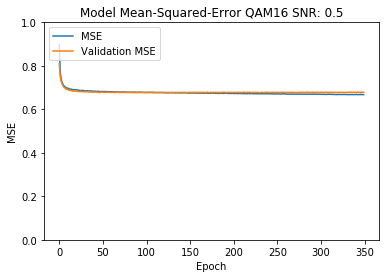

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_242 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_81 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_243 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


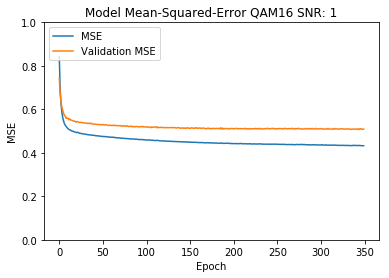

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_245 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_82 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_246 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


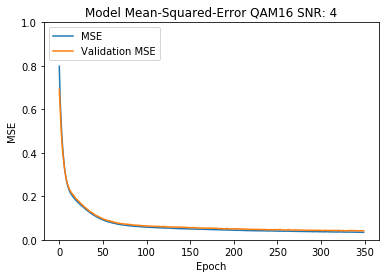

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_247 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_248 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_83 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_249 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


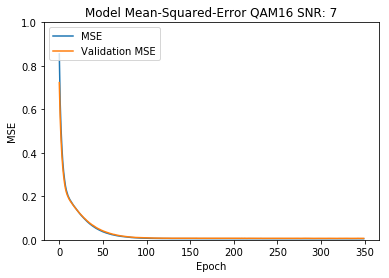

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_250 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_251 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_84 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_252 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


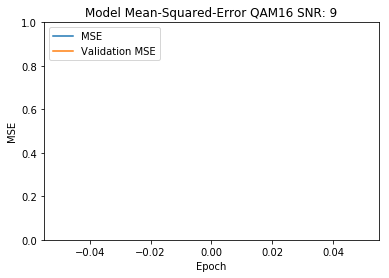

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_254 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_85 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_255 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


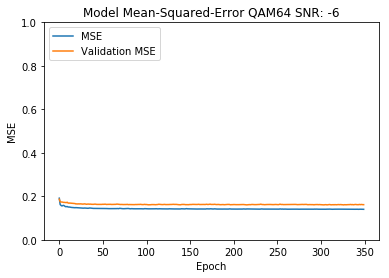

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_257 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_86 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_258 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


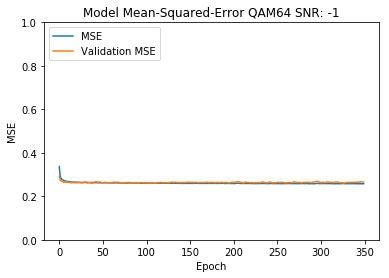

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_259 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_260 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_87 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_261 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


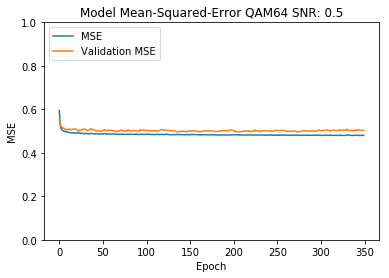

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_263 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_88 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


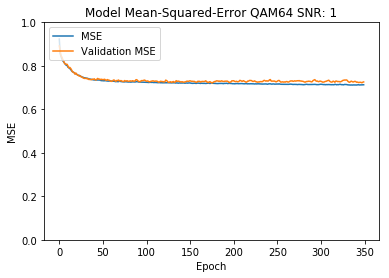

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_266 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_89 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_267 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


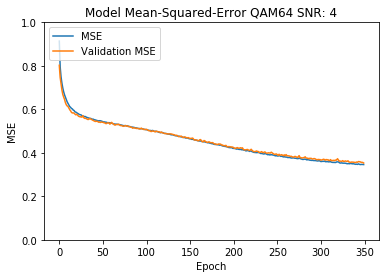

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_269 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_90 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_270 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


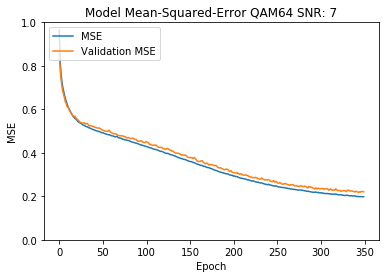

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_271 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_272 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_91 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_273 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


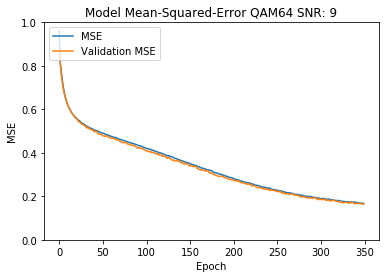

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_274 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_275 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_92 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_276 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


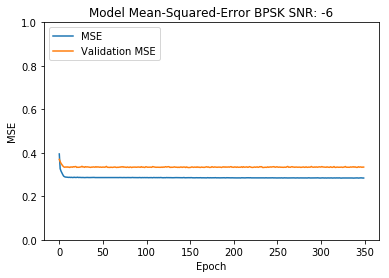

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_277 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_278 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_93 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_279 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


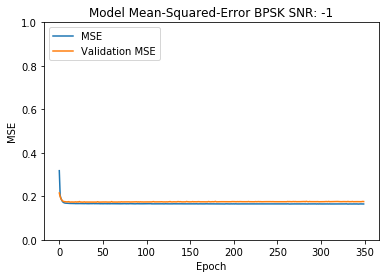

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_281 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_94 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_282 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


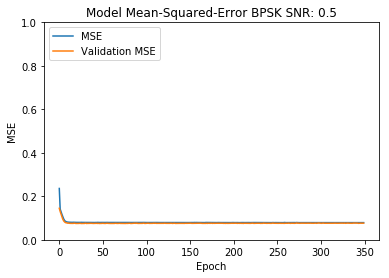

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_283 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_284 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_95 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_285 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


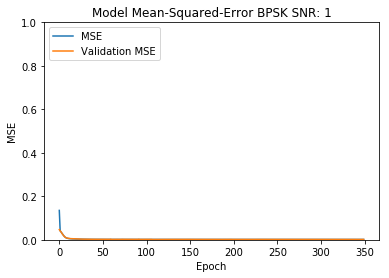

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_286 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_287 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_96 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_288 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


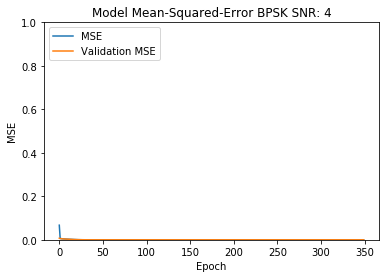

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_289 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_290 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_97 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_291 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


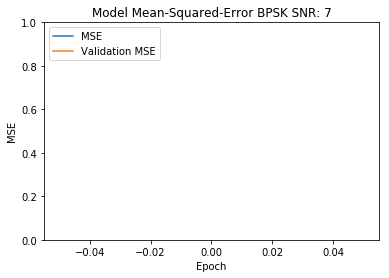

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_292 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_293 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_98 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_294 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


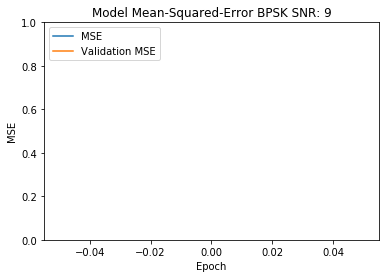

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_295 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_296 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_99 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_297 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


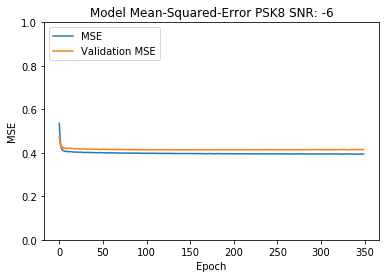

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_298 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_299 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_100 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_300 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


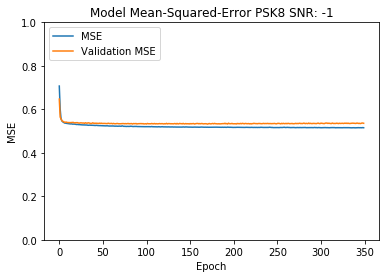

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_302 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_101 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_303 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


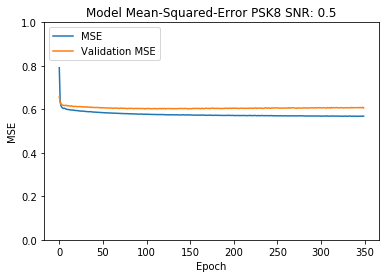

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_304 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_305 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_102 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_306 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


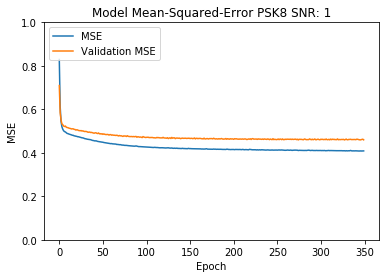

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_307 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_308 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_103 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


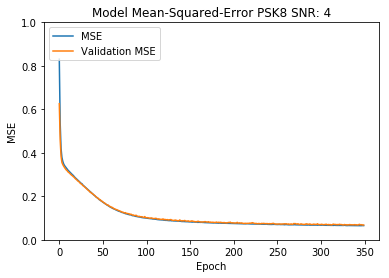

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_310 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_311 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_104 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_312 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


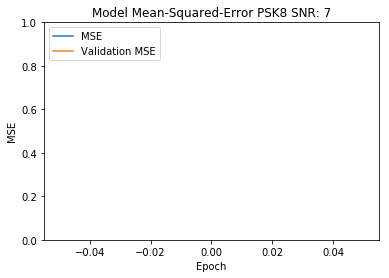

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_313 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_314 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_105 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_315 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


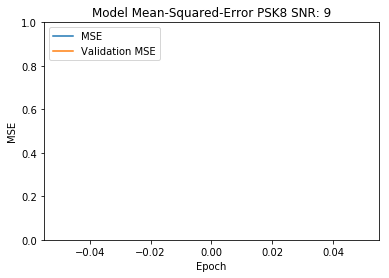

In [13]:
SNRS1 = [-6, -1, 0.5, 1, 4, 7, 9, 13, 18]
def run_simulation(myModems, VARS, SNRS, names, optimizer=Adam):
    counterIndex = 0
    for modem in myModems:
        for noise_var, snr in zip(VARS, SNRS1):
            print(names[counterIndex])
            channel = rayleigh_multipath(noise_var, VAR_RAYLEIGH, [1.0, 0.7, 0.1, 0.3])
            myModel = generateModel(bps = modem.bit_num)
            #sending even number of bits through modulator
            
            if (names[counterIndex] != 'BPSK'):
                length = len(data)
                num_chunks = int(np.floor_divide(length, modem.bit_num))
                proc_data = data[:length*num_chunks]
            else:
                proc_data = data

            #adding AWGN and Rayleigh fading in channel
            TX_data = modem.TX(proc_data)
            X_pre = (channel.awgn(TX_data))
            X = []
            TX = []
            for x in X_pre:
                X.append([x.real, x.imag])
            for x in TX_data:
                TX.append([x.real, x.imag])
            X = np.array(X)
            TX = np.array(TX)
            y = []
            #calculate LLRs of the transmitted symbols before channels
            for symbol in TX:
                complex_symbol = symbol[0] + 1j*symbol[1]
                #calculate the LLRs off of the known approximate of gaussian  and rayleigh variances
                ele = calc_llr(modem.dict, complex_symbol, h=VAR_RAYLEIGH, var = noise_var)
                ele = np.tanh(ele)
                y.append(ele)

            y = np.array(y)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            myModel.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
            epochs = 350
            mselist = []
            val_mselist = []
            for i in range(epochs):
                history=myModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, verbose=False)
                mselist.append(history.history['mean_squared_error'])
                val_mselist.append(history.history['val_mean_squared_error'])
                
            model_list.append(myModel)
            fig = plt.figure()
            ax = plt.gca()
            ax.set_ylim(0, 1)
            plt.plot(mselist)
            plt.plot(val_mselist)
            plt.title('Model Mean-Squared-Error %s SNR: %s' % (names[counterIndex], snr))
            plt.ylabel('MSE')
            plt.xlabel('Epoch')
            plt.legend(['MSE', 'Validation MSE'], loc = 'upper left')
            plt.show()
        counterIndex += 1
run_simulation(myModems,VARS,SNRS,names,optimizer=Adam)

The second simulation was run for a new set of SNRS [-6, -1, 0.5, 1, 4, 7, 9, 13, 18]. Here we can see that for each plot the MSE and Validation MSE have a larger difference than the previous simulation. 

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_559 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_560 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_187 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_561 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


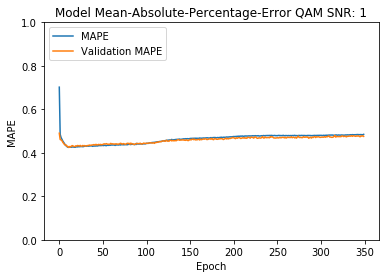

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_562 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_563 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_188 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_564 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


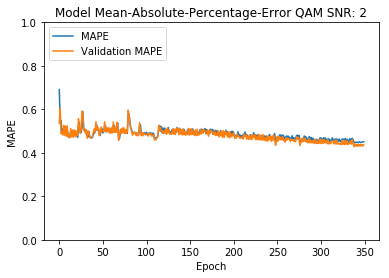

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_565 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_566 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_189 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_567 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


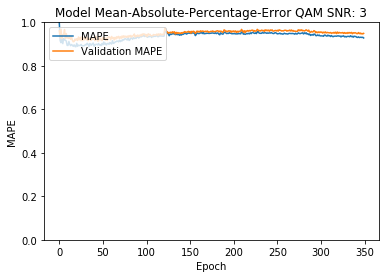

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_568 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_569 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_190 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_570 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


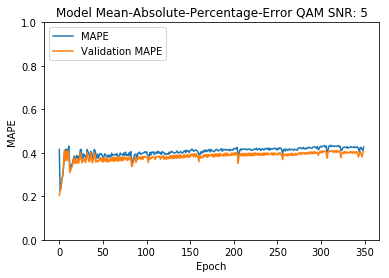

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_571 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_572 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_191 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_573 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


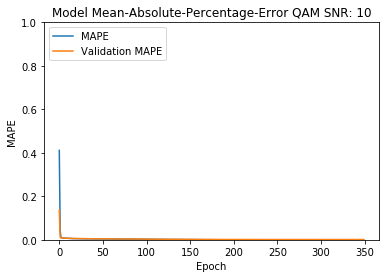

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_574 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_575 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_192 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_576 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/Users/atharvapadhye/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


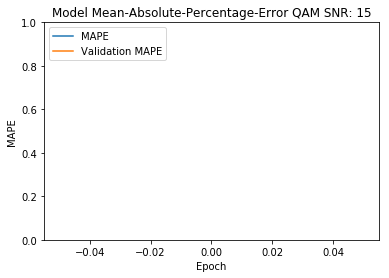

QAM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_577 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_578 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_193 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_579 (Dense)            (None, 2)                 258       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________


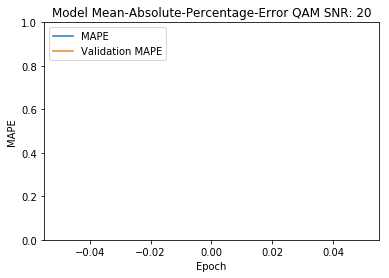

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_580 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_581 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_194 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_582 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


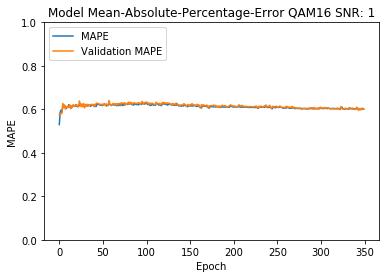

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_583 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_584 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_195 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_585 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


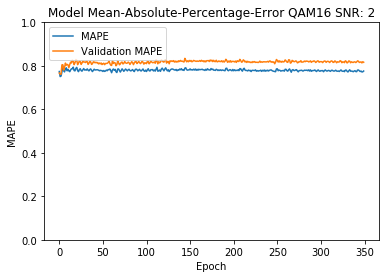

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_586 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_587 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_196 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_588 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


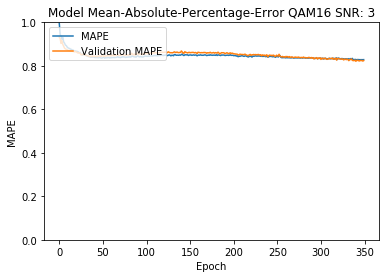

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_589 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_590 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_197 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_591 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


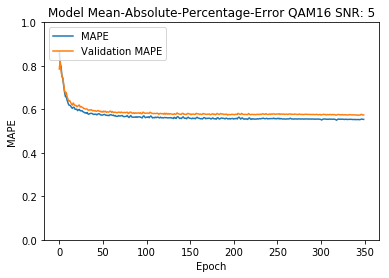

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_592 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_593 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_198 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_594 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


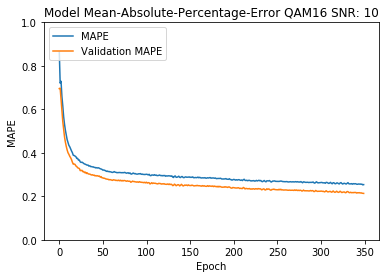

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_595 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_596 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_199 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_597 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


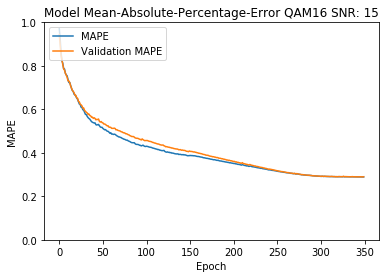

QAM16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_598 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_599 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_200 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_600 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


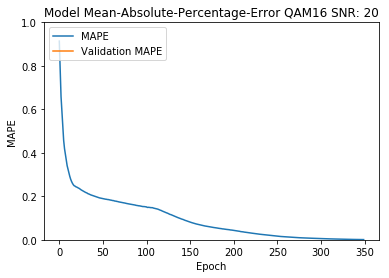

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_601 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_602 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_201 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_603 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


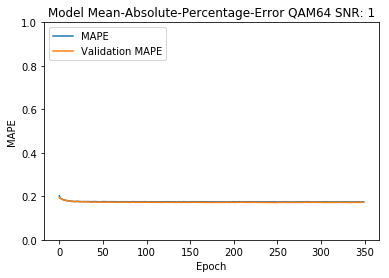

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_604 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_605 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_202 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_606 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


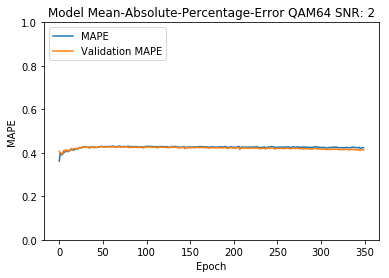

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_607 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_608 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_203 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_609 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


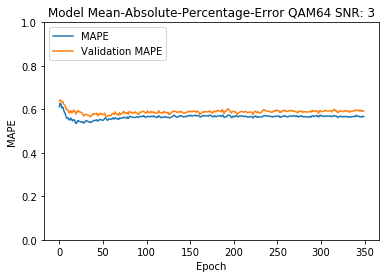

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_610 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_611 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_204 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_612 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


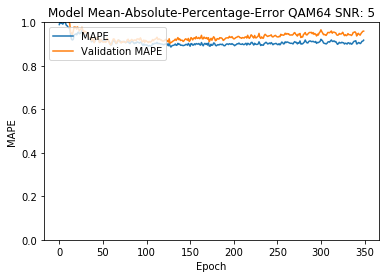

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_613 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_614 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_205 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_615 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


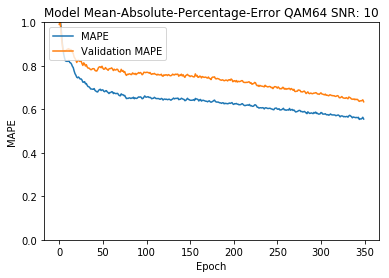

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_616 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_617 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_206 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_618 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


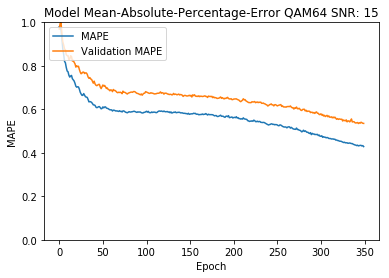

QAM64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_619 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_620 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_207 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_621 (Dense)            (None, 6)                 774       
Total params: 1,164
Trainable params: 1,164
Non-trainable params: 0
_________________________________________________________________


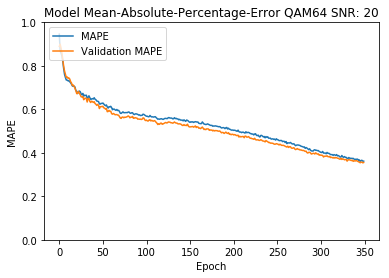

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_622 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_623 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_208 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_624 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


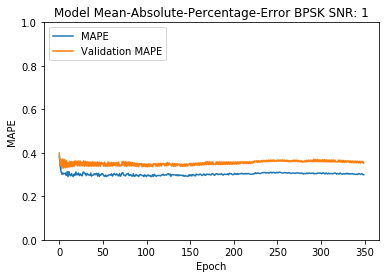

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_625 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_626 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_209 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_627 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


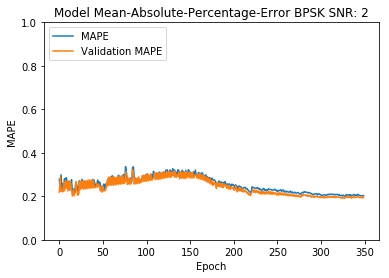

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_628 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_629 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_210 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_630 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


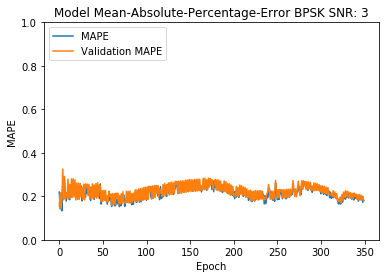

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_631 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_632 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_211 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_633 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


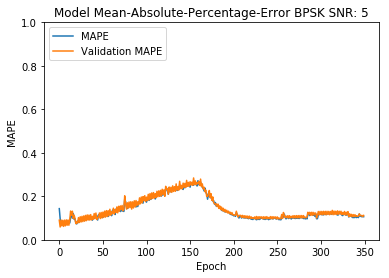

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_634 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_635 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_212 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_636 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


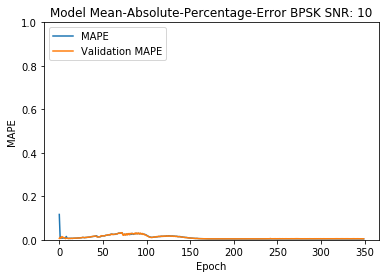

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_637 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_638 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_213 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_639 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


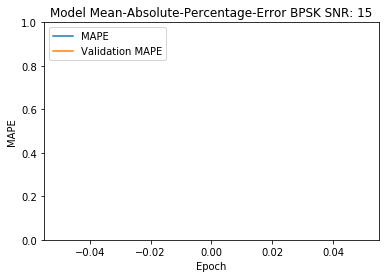

BPSK
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_640 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_641 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_214 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_642 (Dense)            (None, 1)                 129       
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________


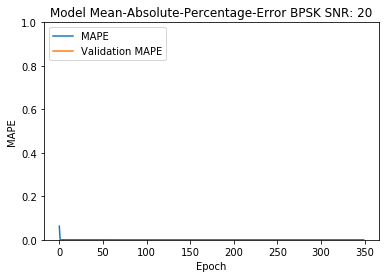

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_643 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_644 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_215 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_645 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


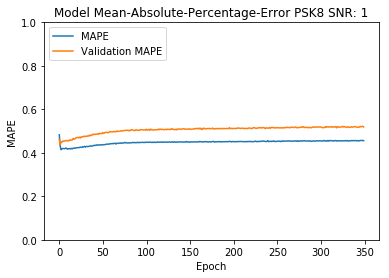

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_646 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_647 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_216 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_648 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


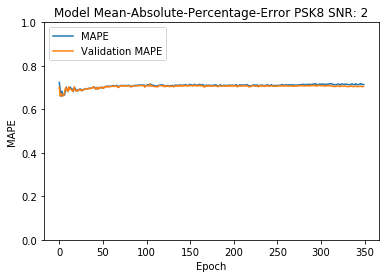

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_649 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_650 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_217 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_651 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


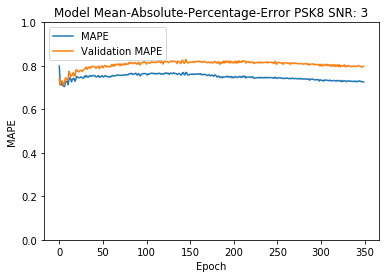

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_652 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_653 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_218 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_654 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


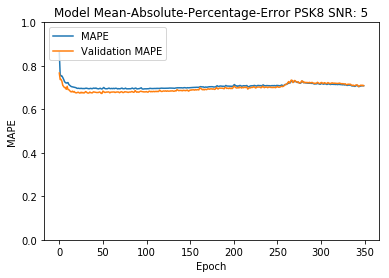

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_655 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_656 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_219 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_657 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


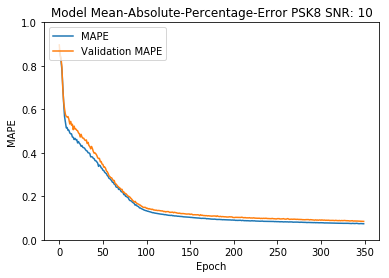

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_658 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_659 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_220 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_660 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


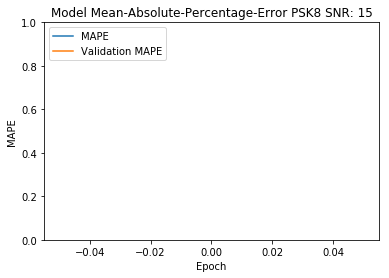

PSK8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_661 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_662 (Dense)            (None, 128)               384       
_________________________________________________________________
activation_221 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_663 (Dense)            (None, 4)                 516       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


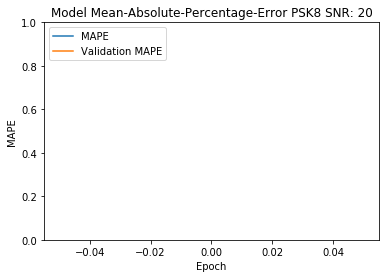

In [19]:
#FeedForward Simulation, used atom optimizer as it runs fast and goes through gradients and doesn't get stuck on local minimas
#can try to use RMSPROP
def run_simulation(myModems, VARS, SNRS, names, optimizer=Adam):
    counterIndex = 0
    for modem in myModems:
        for noise_var, snr in zip(VARS, SNRS):
            print(names[counterIndex])
            channel = rayleigh_multipath(noise_var, VAR_RAYLEIGH, [1.0, 0.7, 0.1, 0.3])
            myModel = generateModel(bps = modem.bit_num)
            #sending even number of bits through modulator
            
            if (names[counterIndex] != 'BPSK'):
                length = len(data)
                num_chunks = int(np.floor_divide(length, modem.bit_num))
                proc_data = data[:length*num_chunks]
            else:
                proc_data = data

            #adding AWGN and Rayleigh fading in channel
            TX_data = modem.TX(proc_data)
            X_pre = (channel.awgn(TX_data))
            X = []
            TX = []
            for x in X_pre:
                X.append([x.real, x.imag])
            for x in TX_data:
                TX.append([x.real, x.imag])
            X = np.array(X)
            TX = np.array(TX)
            y = []
            #calculate LLRs of the transmitted symbols before channels
            for symbol in TX:
                complex_symbol = symbol[0] + 1j*symbol[1]
                #calculate the LLRs off of the known approximate of gaussian  and rayleigh variances
                ele = calc_llr(modem.dict, complex_symbol, h=VAR_RAYLEIGH, var = noise_var)
                ele = np.tanh(ele)
                y.append(ele)

            y = np.array(y)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            myModel.compile(loss='mean_absolute_percentage_error', optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
            epochs = 350
            mselist = []
            val_mselist = []
            for i in range(epochs):
                history=myModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, verbose=False)
                mselist.append(history.history['mean_squared_error'])
                val_mselist.append(history.history['val_mean_squared_error'])
            #used MSE because it is a good regression problem to calculate LLR, seemed most obvious.
            #other methods include Mahattan distance and Euclidian distance
            model_list.append(myModel)
            fig = plt.figure()
            ax = plt.gca()
            ax.set_ylim(0, 1)
            plt.plot(mselist)
            plt.plot(val_mselist)
            plt.title('Model Mean-Absolute-Percentage-Error %s SNR: %s' % (names[counterIndex], snr))
            plt.ylabel('MAPE')
            plt.xlabel('Epoch')
            plt.legend(['MAPE', 'Validation MAPE'], loc = 'upper left')
            plt.show()
        counterIndex += 1
run_simulation(myModems,VARS,SNRS,names,optimizer=Adam)
#overfitting can happen if you train a model for too long on a specific data set, used validation to see if overfitting isn't happening
#As SNR increase it gets converge to 0